# Deep Learning : 3D shapes




Same as CNN_training but focused on the error computation for the parameters R and n of noisy elliptical galaxies.

## Imports

In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=500,precision=2,suppress=True)
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable


from IPython.display import clear_output

2023-01-23 13:16:06.817582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utils

In [2]:
def progression(i, n):
    i += 1
    k = int(i/n*20)
    print(f'\rProgression:[{k*"#"}{(20-k)*" "}] [{(i/n*100):.0f} %]',
          end='' if i != n else "\n", flush=True)

In [3]:
def plot_loss_acc(history):

    fig, axs = plt.subplots(1,2,figsize=(15,4))
    axs[0].set_title("Loss")
    axs[0].plot(history.history['loss'], label='loss')
    axs[0].plot(history.history['val_loss'], label='val_loss')
    axs[0].set_xlabel('Epoch #')
    axs[0].legend()

    axs[1].set_title("Accuracy")
    axs[1].plot(history.history['accuracy'], label='accuracy')
    axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
    axs[1].set_xlabel('Epoch #')
    axs[1].legend();

In [4]:
def plot_test_pred(Y_test, Y_pred, titles) :
    n = Y_pred.shape[-1]

    if n<=2 :
      if n == 2 :
        fig, axs = plt.subplots(1,2, figsize=(7*n,4))
        for i in range(n) :
            axs[i].set_title(titles[i])
            axs[i].scatter(Y_test[:,i], Y_pred[:,i], alpha=0.1)
            abscisse=np.linspace(0,np.max(Y_test[:,i]),1000)
            axs[i].plot(abscisse, abscisse, 'k')
            axs[i].set_xlabel('Test')
            axs[i].set_ylabel('Pred')
      if n== 1 :
          fig, axs = plt.subplots(1,1, figsize=(10,4))
          axs.set_title(titles[0])
          axs.scatter(Y_test[:,0], Y_pred[:,0], alpha=0.1)
          abscisse=np.linspace(0,np.max(Y_test[:,0]),1000)
          axs.plot(abscisse, abscisse, 'k')
          axs.set_xlabel('Test')
          axs.set_ylabel('Pred')

    else :
      fig, axs = plt.subplots( (n+1)//2,2, figsize=(14, 3*n))
      for i in range(n) :
          axs[i//2, i%2].set_title(titles[i])
          axs[i//2, i%2].scatter(Y_test[:,i], Y_pred[:,i], alpha=0.1)
          abscisse=np.linspace(0,np.max(Y_test[:,i]),1000)
          axs[i//2, i%2].plot(abscisse, abscisse, 'k')
          axs[i//2, i%2].set_xlabel('Test')
          axs[i//2, i%2].set_ylabel('Pred')
    plt.tight_layout();

In [5]:
def plot_test_pred_corr(Y_test, Y_pred, titles, Corr, corr_label) :

    n = Y_pred.shape[-1]

    if n<=2 :
        if n == 2 :
            fig, axs = plt.subplots(1,2, figsize=(7*n,4))
            for i in range(n) :
                axs[i].set_title(titles[i])
                im = axs[i].scatter(Y_test[:,i],Y_pred[:,i],c=Corr,edgecolors=None,alpha=0.7,marker='o',cmap='jet')
                abscisse=np.linspace(0,np.max(Y_test[:,i]),1000)
                axs[i].plot(abscisse, abscisse, 'k')
                axs[i].set_xlabel('Test')
                xs[i].set_ylabel('Pred')
                divider = make_axes_locatable(axs)
                cax = divider.append_axes('right', size='5%', pad=0.05)
                fig.colorbar(im, cax=cax, orientation='vertical', label=corr_label)
                
        if n== 1 :
            fig, axs = plt.subplots(1,1, figsize=(10,4))
            axs.set_title(titles[0])
            im = axs.scatter(Y_test[:,0],Y_pred[:,0],c=Corr,edgecolors=None,alpha=0.7,marker='o',cmap='jet')
            abscisse=np.linspace(0,np.max(Y_test[:,0]),1000)
            axs.plot(abscisse, abscisse, 'k')
            axs.set_xlabel('Test')
            axs.set_ylabel('Pred')
            divider = make_axes_locatable(axs)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical', label=corr_label)
    else :
        fig, axs = plt.subplots( (n+1)//2,2, figsize=(14, 3*n))
        for i in range(n) :
            xs[i//2, i%2].set_title(titles[i])
            im = axs[i//2, i%2].scatter(Y_test[:,i],Y_pred[:,i],c=Corr,edgecolors=None,alpha=0.7,marker='o',cmap='jet')
            abscisse=np.linspace(0,np.max(Y_test[:,i]),1000)
            axs[i//2, i%2].plot(abscisse, abscisse, 'k')
            axs[i//2, i%2].set_xlabel('Test')
            axs[i//2, i%2].set_ylabel('Pred')
            divider = make_axes_locatable(axs[i//2, i%2])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical', label=corr_label)
    plt.tight_layout();

## Data

### Import

In [6]:
catalog='../Data/ImageCat.txt'
filename=np.genfromtxt(catalog,skip_header=1,dtype='U60',usecols=0)
data=np.genfromtxt(catalog,skip_header =1, usecols=[1,2,3,4,5,6,7])  #filename	log(M/M_sun)	r_2/kpc	n	q=b/a	p=c/b	phi/pi	theta/pi

### Treatment

In [8]:
logM = np.copy(data[:,0])
R    = np.copy(data[:,1])
n    = np.copy(data[:,2])
q    = np.copy(data[:,3])
p    = np.copy(data[:,4])
phi  = np.copy(data[:,5])
theta= np.copy(data[:,6])

R4  = R/4.
n10 = n/10.

In [10]:
Y = np.stack([R4, n10, q, p, phi, theta],axis=1)
Y = Y.astype('float32')

Y_without_norm = np.stack([R, n, q, p, phi, theta],axis=1)
Y_without_norm = Y_without_norm.astype('float32')
Y.shape, Y.dtype

((10120, 6), dtype('float32'))

In [11]:
D1 = np.load('../Data/IMAGE/'+ filename[1])['imT']
D1.shape

(100, 100)

In [12]:
size = Y.shape[0] 
Y = Y[:size]
D=np.zeros((size,D1.shape[0],D1.shape[0],1)) 
for i in range(size):

    Di=np.load('../Data/IMAGE/'+ filename[i])  
    imTi=np.log10(Di['imT'])
    imTi_min=imTi[imTi>0.].min()
    imTi_max=np.amax(imTi)
    imTi[imTi<0.]=imTi_min
    D[i,:,:,0]=imTi

D = D.astype('float32') 


ngal=np.shape(D)[0]
print("The catalog comprises %i galaxies"%ngal)

The catalog comprises 10120 galaxies


### Plot one galaxy

[0.04 0.19 0.23 0.12 0.35 0.33]


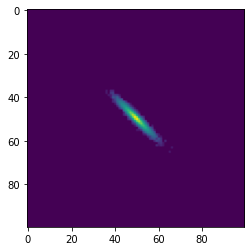

In [13]:
i=1000
print(Y[i,:])
plt.imshow(D[i,:,:,0]) 
plt.show()


## Trainers

In [13]:
def R_2(y, y_pred):
    residual = tf.reduce_sum((y - y_pred)**2)
    total = tf.reduce_sum((y - tf.reduce_mean(y))**2)
    return 1.0 -residual / (total+1e-6)

In [14]:
def R_abs(y, y_pred): #Score pour la regression
    residual = tf.reduce_sum(tf.abs(y - y_pred))
    total = tf.reduce_sum(tf.abs(y - tf.reduce_mean(y)))
    return tf.clip_by_value(1.0 - residual / (total+1e-6),-2,1)

Validation: step:5828, val_loss:0.002, val_acc:-24848.029
nombre d'époque réalisée : 1942


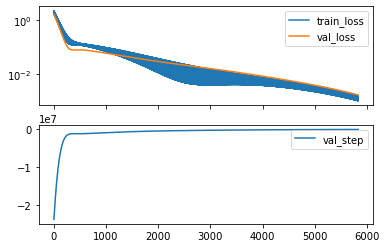

In [16]:
#Test the trainer with regression
def test_regression():
    X=tf.random.uniform([100,10,1])
    Y=tf.ones([100,1])
    model=tf.keras.Sequential([tf.keras.layers.Flatten(),tf.keras.layers.Dense(1)])
    trainer=Trainer(X,Y,model,batch_size=32)
    trainer.train(0.5)

test_regression()

## Models

### Model 1 : Convolution

In [17]:
class Model1(tf.keras.Model):

    def __init__(self, dimout):
        super().__init__()
        self.layer1=tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')
        #self.dropout1=tf.keras.layers.Dropout(0.25)
        self.layer2=tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')
        self.layer3=tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')
        self.layer4=tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')
        self.layer5=tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')

        self.flatten=tf.keras.layers.Flatten()
        self.dense1=tf.keras.layers.Dense(1024,activation='relu')
        self.dense2=tf.keras.layers.Dense(512,activation='relu')
        self.dense3=tf.keras.layers.Dense(dimout)
        print(f"Dim out = {dimout}")

        self.max_pool=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))


    @tf.function
    def call(self,X,training=True):

        out=self.layer1(X)
        #out=self.dropout1(out, training)
        out=self.max_pool(out)
        out=self.layer2(out)
        out=self.max_pool(out)
        out=self.layer3(out)
        out=self.max_pool(out)
        out=self.layer4(out)
        out=self.max_pool(out)
        out=self.layer5(out)
        out=self.max_pool(out)

        out=self.flatten(out)

        out=self.dense1(out)
        out=self.dense2(out)
        
        return self.dense3(out)



## Tests

In [18]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

[0.79 0.84 0.47 0.17 0.29 0.48]


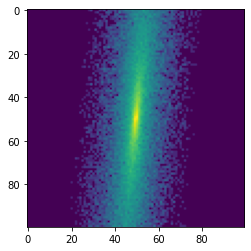

In [19]:
#Relancer plusieurs fois la cellule pour voir que l'on permute aléatoirement les données
shuffle= np.arange(D.shape[0])
np.random.shuffle(shuffle)

Y = Y[shuffle]
D = D[shuffle]
#sigma = sigma[shuffle]

print(Y[100])
plt.imshow(D[100,:,:,0]);

In [20]:
res_data = pd.DataFrame()

l = len(D)
train_size = int(0.7 * l)
val_size = int(0.15 * l)

X_train = D[:train_size]
Y_train = Y[:train_size]
Y_train_without_norm = Y_without_norm[:train_size]

X_val = D[train_size:train_size+val_size]
Y_val = Y[train_size:train_size+val_size]
Y_val_without_norm = Y_without_norm[train_size:train_size+val_size]

X_test = D[train_size+val_size:]
Y_test = Y[train_size+val_size:]
Y_test_without_norm = Y_without_norm[train_size+val_size:]


### Parameter n

#### With normalization

##### Initial

In [24]:
Y_train_n = Y_train[:,1]
Y_train_n = Y_train_n[:, None]

Y_val_n = Y_val[:, 1]
Y_val_n = Y_val_n[:, None]

Y_test_n = Y_test[:, 1]
Y_test_n = Y_test_n[:, None]

Y_train_n.shape, Y_val_n.shape, Y_test_n.shape

((7084, 1), (1518, 1), (1518, 1))

In [ ]:
plot_model(model1)

In [ ]:
model1 = Model1(1)

model1.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

batch_size = 64
nb_epoch = 50

history = model1.fit(X_train, Y_train_n,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_n),
    callbacks=[model_checkpoint_callback])


model1.load_weights(checkpoint_filepath)


# Save the weights
model1.save_weights('./checkpoints/my_checkpoint')

In [180]:

# Create a new model instance
model1 = Model1(1)

# Restore the weights

model1.load_weights('./checkpoints/my_checkpoint')
model1.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

# Evaluate the model
loss, acc = model1.evaluate(X_train, Y_train_n, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Dim out = 1
222/222 - 11s - loss: 0.0011 - accuracy: 2.8233e-04 - 11s/epoch - 49ms/step
Restored model, accuracy:  0.03%


In [196]:
Y_pred_n = model1(X_test)
Y_pred_n.shape

TensorShape([1518, 1])

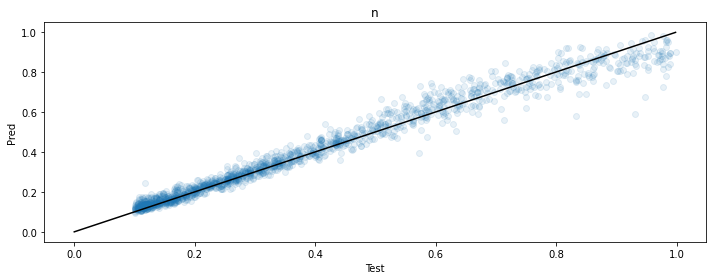

In [19]:
plot_test_pred(Y_test_n, Y_pred_n, ["n"])
#plt.savefig('pred_n.png', dpi=100)

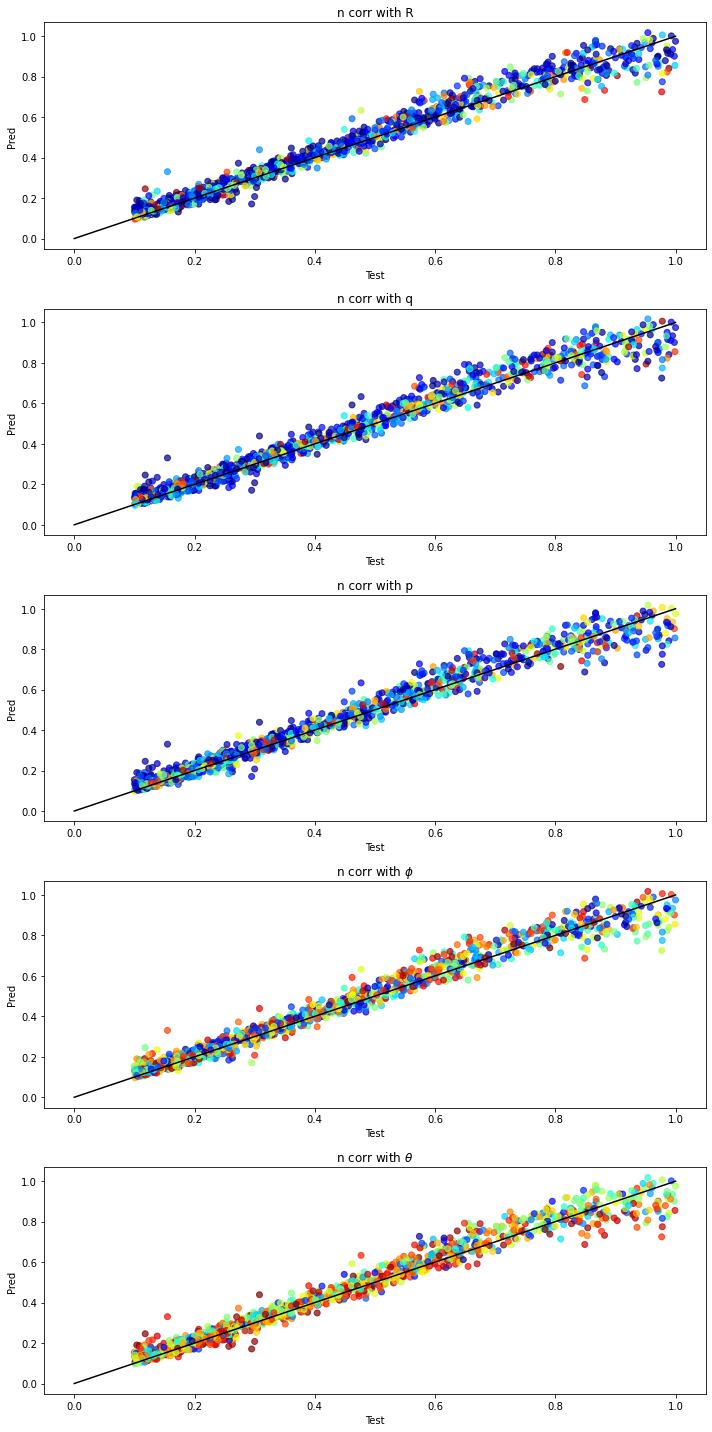

In [37]:
fig, axs = plt.subplots(5,1, figsize=(10,20))

axs[0].set_title("n corr with R")
axs[0].scatter(Y_test_n[:,0],Y_pred_n[:,0],c=Y_test[:,0],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_n[:,0]),1000)
axs[0].plot(abscisse, abscisse, 'k')
axs[0].set_xlabel('Test')
axs[0].set_ylabel('Pred')

axs[1].set_title("n corr with q")
axs[1].scatter(Y_test_n[:,0],Y_pred_n[:,0],c=Y_test[:,2],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_n[:,0]),1000)
axs[1].plot(abscisse, abscisse, 'k')
axs[1].set_xlabel('Test')
axs[1].set_ylabel('Pred')

axs[2].set_title("n corr with p")
axs[2].scatter(Y_test_n[:,0],Y_pred_n[:,0],c=Y_test[:,3],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_n[:,0]),1000)
axs[2].plot(abscisse, abscisse, 'k')
axs[2].set_xlabel('Test')
axs[2].set_ylabel('Pred')

axs[3].set_title(r"n corr with $\phi$")
axs[3].scatter(Y_test_n[:,0],Y_pred_n[:,0],c=Y_test[:,4],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_n[:,0]),1000)
axs[3].plot(abscisse, abscisse, 'k')
axs[3].set_xlabel('Test')
axs[3].set_ylabel('Pred')

axs[4].set_title(r"n corr with $\theta$")
axs[4].scatter(Y_test_n[:,0],Y_pred_n[:,0],c=Y_test[:,5],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_n[:,0]),1000)
axs[4].plot(abscisse, abscisse, 'k')
axs[4].set_xlabel('Test')
axs[4].set_ylabel('Pred')


plt.tight_layout()

##### Test on trained NN with noisy data

In [25]:
import random

def noisy_data(data, SNR) :
    data_noisy = np.copy(data)
    for i in range(data.shape[0]) :
        max_int = np.max(data[i])
        noise = np.random.normal(0, 1, (data.shape[1], data.shape[2]))
        noise = noise / np.max(noise) * max_int/SNR
        data_noisy[i] = data[i] + np.reshape(noise, (data.shape[1], data.shape[2],1))
    return data_noisy
    

In [27]:
from sklearn.metrics import mean_squared_error

# Compute the RMSE
#rmse = np.sqrt(mean_squared_error(Y_test_n, Y_pred_n))

In [ ]:
rmse=[]
for snr in range(1,101):
    X_test_noisy = noisy_data(X_test, snr)
    Y_pred_n_noisy = model1(X_test_noisy)
    rmse.append(np.sqrt(mean_squared_error(Y_test_n, Y_pred_n_noisy)))


In [84]:
plt.rcdefaults()

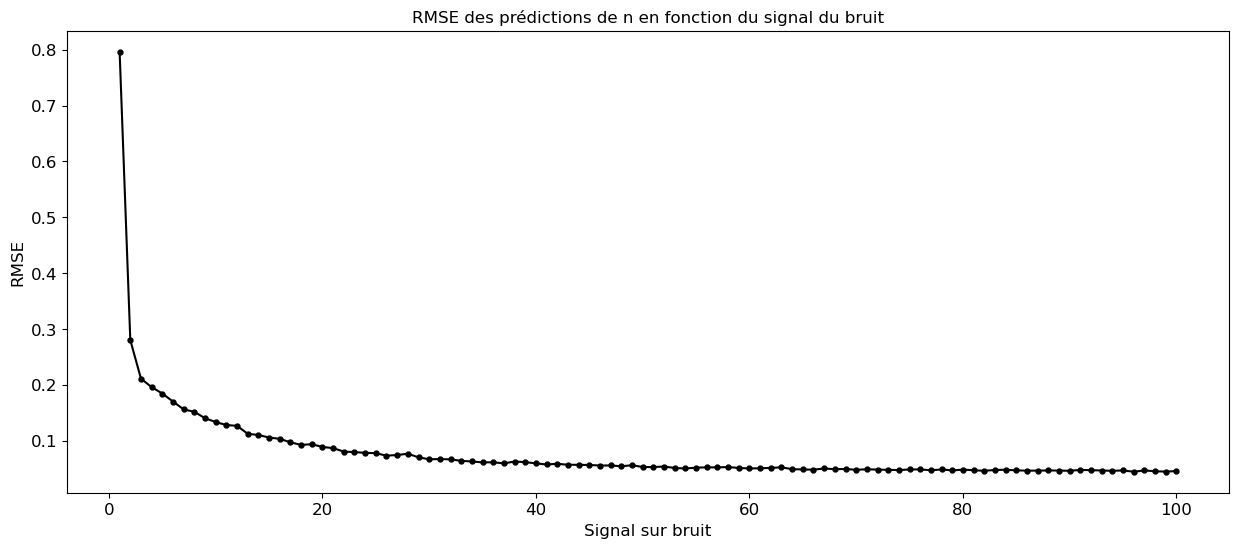

In [90]:
fig, ax = plt.subplots(1, figsize=(15,6))
ax.scatter(range(1,101), rmse, marker='.', color='black', s=50)
ax.plot(range(1,101), rmse, color='black')
ax.set_xlabel('Signal sur bruit')
ax.set_ylabel('RMSE')
ax.set_title('RMSE des prédictions de n en fonction du signal du bruit')

ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
    
#plt.savefig('images/noisy/rmse_vs_snr.png', dpi=100)

In [43]:
SNR = 50
X_test_noisy = noisy_data(X_test, SNR)

Y_pred_n_noisy = model1(X_test_noisy)
Y_pred_n_noisy.shape

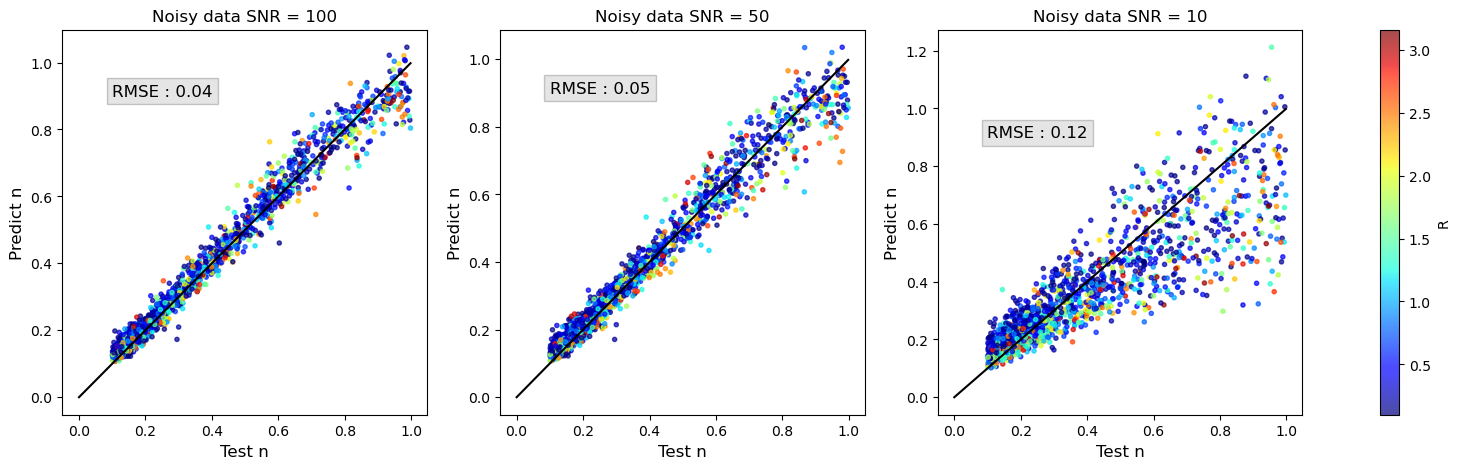

In [213]:
fig, ax =  plt.subplots(1,3, figsize = (20,5))

abscisse=np.linspace(0,np.max(Y_test_n[:,0]),1000)

SNR = 100
X_test_noisy = noisy_data(X_test, SNR)
Y_pred_n_noisy = model1(X_test_noisy)
ax[0].set_title("Noisy data SNR = %s"%SNR, size=12)
im = ax[0].scatter(Y_test_n[:,0],Y_pred_n_noisy[:,0],c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[0].plot(abscisse, abscisse, 'k')
ax[0].set_xlabel('Test n', size=12)
ax[0].set_ylabel('Predict n', size=12)
ax[0].text(0.1, 0.9, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_n, Y_pred_n_noisy)),2), fontsize=12,
          bbox=dict(facecolor='grey', alpha=0.2))

SNR = 50
X_test_noisy = noisy_data(X_test, SNR)
Y_pred_n_noisy = model1(X_test_noisy)
ax[1].set_title("Noisy data SNR = %s"%SNR, size=12)
im = ax[1].scatter(Y_test_n[:,0],Y_pred_n_noisy[:,0],c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[1].plot(abscisse, abscisse, 'k')
ax[1].set_xlabel('Test n', size=12)
ax[1].set_ylabel('Predict n', size=12)
ax[1].text(0.1, 0.9, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_n, Y_pred_n_noisy)),2), fontsize=12,
          bbox=dict(facecolor='grey', alpha=0.2))

SNR = 10
X_test_noisy = noisy_data(X_test, SNR)
Y_pred_n_noisy = model1(X_test_noisy)
ax[2].set_title("Noisy data SNR = %s"%SNR, size=12)
im = ax[2].scatter(Y_test_n[:,0],Y_pred_n_noisy[:,0],c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[2].plot(abscisse, abscisse, 'k')
ax[2].set_xlabel('Test n', size=12)
ax[2].set_ylabel('Predict n', size=12)
ax[2].text(0.1, 0.9, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_n, Y_pred_n_noisy)),2), fontsize=12,
          bbox=dict(facecolor='grey', alpha=0.2))

fig.colorbar(im, ax=ax, orientation='vertical', label='R')

#plt.savefig('images/noisy/corr_comp_noisy.png',dpi=100)

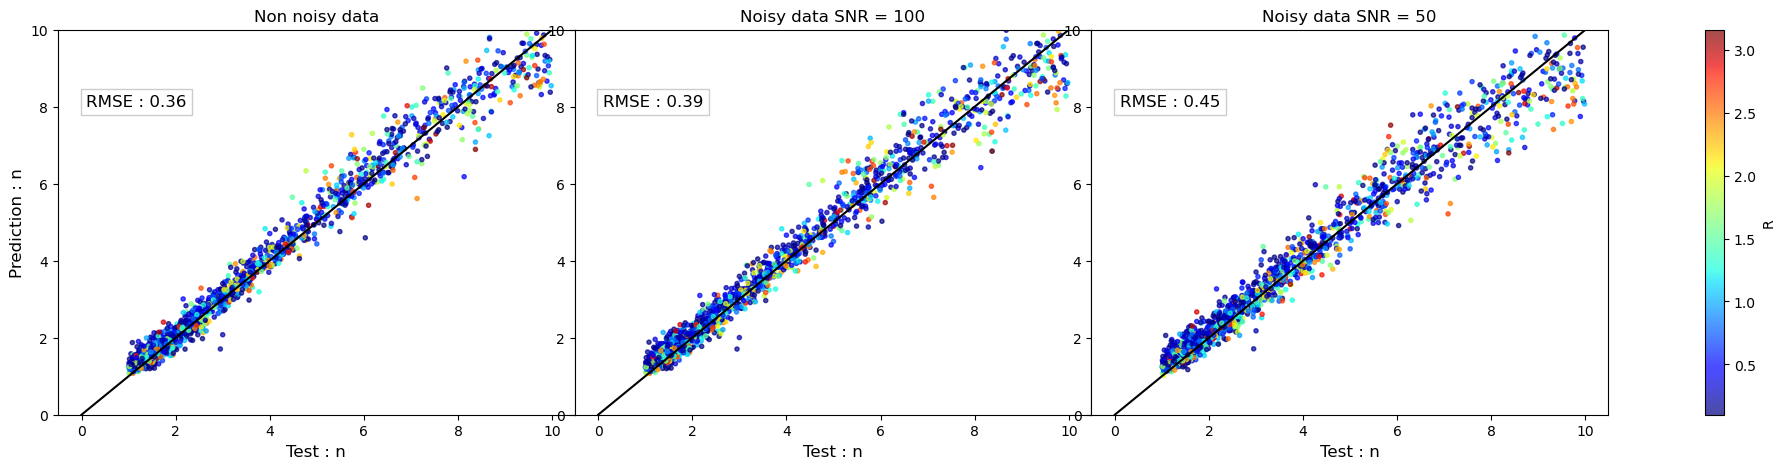

In [245]:
fig, ax =  plt.subplots(1,3, figsize = (25,5))

abscisse=np.linspace(0,np.max(Y_test_n[:,0])*10,1000)

ax[0] = plt.subplot2grid((1, 3), (0, 0), colspan=1)
ax[0].set_title("Non noisy data", size=12)
im = ax[0].scatter(Y_test_n[:,0]*10,Y_pred_n[:,0]*10,c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[0].plot(abscisse, abscisse, 'k')
ax[0].set_xlabel('Test : n', size=12)
ax[0].set_ylabel('Prediction : n', size=12)
ax[0].text(0.1, 8, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_n*10, Y_pred_n*10)),2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.2))
ax[0].set_ylim(0,10)


SNR = 100
X_test_noisy = noisy_data(X_test, SNR)
Y_pred_n_noisy = model1(X_test_noisy)
ax[1] = plt.subplot2grid((1, 3), (0, 1), colspan=1, sharey=ax[0])
ax[1].set_title("Noisy data SNR = %s"%SNR, size=12)
im = ax[1].scatter(Y_test_n[:,0]*10,Y_pred_n_noisy[:,0]*10,c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[1].plot(abscisse, abscisse, 'k')
ax[1].set_xlabel('Test : n', size=12)
ax[1].text(0.1, 8, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_n*10, Y_pred_n_noisy*10)),2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.2))
ax[1].set_ylim(0,10)

SNR = 50
X_test_noisy = noisy_data(X_test, SNR)
Y_pred_n_noisy = model1(X_test_noisy)
ax[2] = plt.subplot2grid((1, 3), (0, 2), colspan=1, sharey=ax[0])
ax[2].set_title("Noisy data SNR = %s"%SNR, size=12)
im = ax[2].scatter(Y_test_n[:,0]*10,Y_pred_n_noisy[:,0]*10,c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[2].plot(abscisse, abscisse, 'k')
ax[2].set_xlabel('Test : n', size=12)
ax[2].text(0.1, 8, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_n*10, Y_pred_n_noisy*10)),2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.2))
ax[2].set_ylim(0,10)


plt.subplots_adjust(wspace=0)
fig.colorbar(im, ax=ax, orientation='vertical', label='R')

#plt.savefig('images/noisy/corr_comp_noisy8.png',dpi=100)

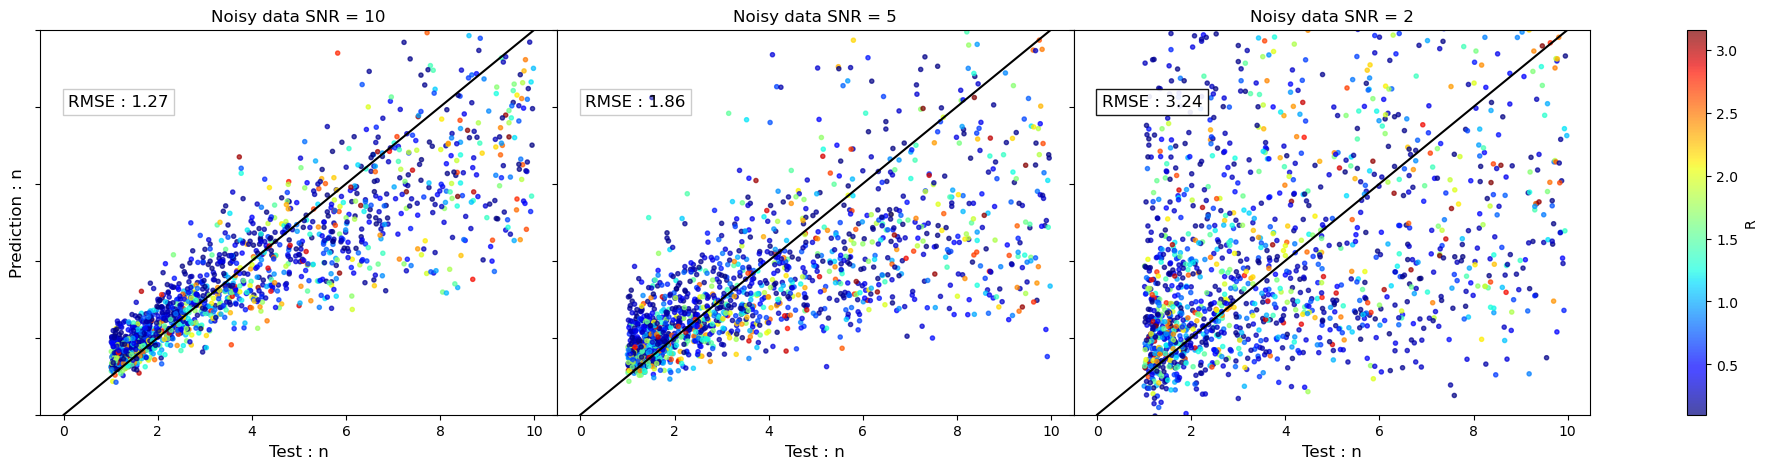

In [248]:
fig, ax =  plt.subplots(1,3, figsize = (25,5))
abscisse=np.linspace(0,np.max(Y_test_n[:,0])*10,1000)

SNR = 10
X_test_noisy = noisy_data(X_test, SNR)
Y_pred_n_noisy = model1(X_test_noisy)
ax[0] = plt.subplot2grid((1, 3), (0, 0), colspan=1)
ax[0].set_title("Noisy data SNR = %s"%SNR, size=12)
im = ax[0].scatter(Y_test_n[:,0]*10,Y_pred_n_noisy[:,0]*10,c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[0].plot(abscisse, abscisse, 'k')
ax[0].set_xlabel('Test : n', size=12)
ax[0].set_ylabel('Prediction : n', size=12)
ax[0].text(0.1, 8, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_n*10, Y_pred_n_noisy*10)),2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.2))
ax[0].set_ylim(0,10)

SNR = 5
X_test_noisy = noisy_data(X_test, SNR)
Y_pred_n_noisy = model1(X_test_noisy)
ax[1] = plt.subplot2grid((1, 3), (0, 1), colspan=1, sharey=ax[0])
ax[1].set_title("Noisy data SNR = %s"%SNR, size=12)
im = ax[1].scatter(Y_test_n[:,0]*10,Y_pred_n_noisy[:,0]*10,c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[1].plot(abscisse, abscisse, 'k')
ax[1].set_xlabel('Test : n', size=12)
ax[1].text(0.1, 8, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_n*10, Y_pred_n_noisy*10)),2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.2))
ax[1].set_ylim(0,10)

SNR = 2
X_test_noisy = noisy_data(X_test, SNR)
Y_pred_n_noisy = model1(X_test_noisy)
ax[2] = plt.subplot2grid((1, 3), (0, 2), colspan=1, sharey=ax[0])
ax[2].set_title("Noisy data SNR = %s"%SNR, size=12)
im = ax[2].scatter(Y_test_n[:,0]*10,Y_pred_n_noisy[:,0]*10,c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[2].plot(abscisse, abscisse, 'k')
ax[2].set_xlabel('Test : n', size=12)
ax[2].text(0.1, 8, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_n*10, Y_pred_n_noisy*10)),2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.9))
ax[2].set_ylim(0,10)

#ax[2].set_yticklabels([])

plt.subplots_adjust(wspace=0)
fig.colorbar(im, ax=ax, orientation='vertical', label='R')

#plt.savefig('images/noisy/corr_comp_noisy9.png',dpi=100)

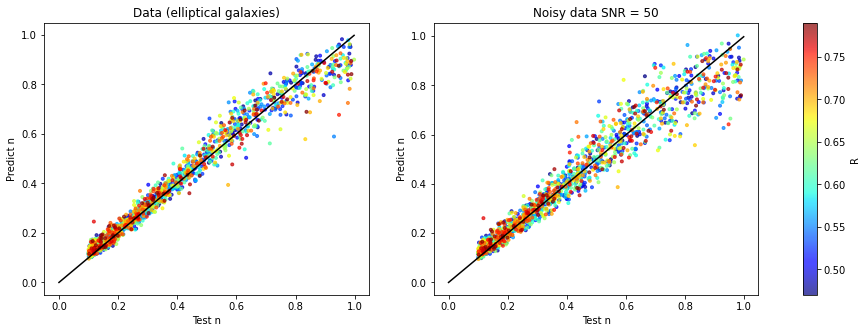

In [117]:
fig, ax =  plt.subplots(1,2, figsize = (16,5))

ax[0].set_title("Data (elliptical galaxies)")
im = ax[0].scatter(Y_test_n[:,0],Y_pred_n[:,0],c=Y_test[:,0],edgecolors=None,alpha=0.7,marker='.',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_n[:,0]),1000)
ax[0].plot(abscisse, abscisse, 'k')
ax[0].set_xlabel('Test n')
ax[0].set_ylabel('Predict n')
fig.colorbar(im, ax=ax, orientation='vertical', label='R')

ax[1].set_title("Noisy data SNR = %s"%SNR)
im = ax[1].scatter(Y_test_n[:,0],Y_pred_n_noisy[:,0],c=Y_test[:,0],edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[1].plot(abscisse, abscisse, 'k')
ax[1].set_xlabel('Test n')
ax[1].set_ylabel('Predict n')

#plt.savefig('images/noisy/corr_comp_noisy.png',dpi=100)

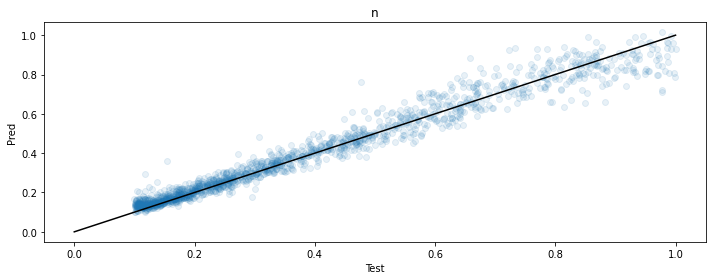

In [98]:
plot_test_pred(Y_test_n, Y_pred_n_noisy, ["n"])
#plt.savefig('n_pred_noisy_SNR_50.png', dpi=100)

#### Training on noisy data

In [127]:
SNR = 50
X_train_noisy = noisy_data(X_train, SNR)
X_val_noisy = noisy_data(X_val, SNR)
#X_test_noisy = noisy_data(X_test, SNR)

In [129]:
noisy_checkpoint_filepath = '/tmp/noisy_checkpoint'
noisy_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=noisy_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

### Parameter R

#### Initial

In [30]:
Y_train_R = Y_train[:,0]
Y_train_R = Y_train_R[:, None]

Y_val_R = Y_val[:, 0]
Y_val_R = Y_val_R[:, None]

Y_test_R = Y_test[:, 0]
Y_test_R = Y_test_R[:, None]

Y_train_R.shape, Y_val_R.shape, Y_test_R.shape

((7084, 1), (1518, 1), (1518, 1))

In [31]:
# Create a new model instance
modelR = Model1(1)

# Restore the weights
modelR.load_weights('./checkpoints/my_checkpoint_R')
modelR.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

Y_pred_R = modelR(X_test)
Y_pred_R.shape

Dim out = 1


TensorShape([1518, 1])

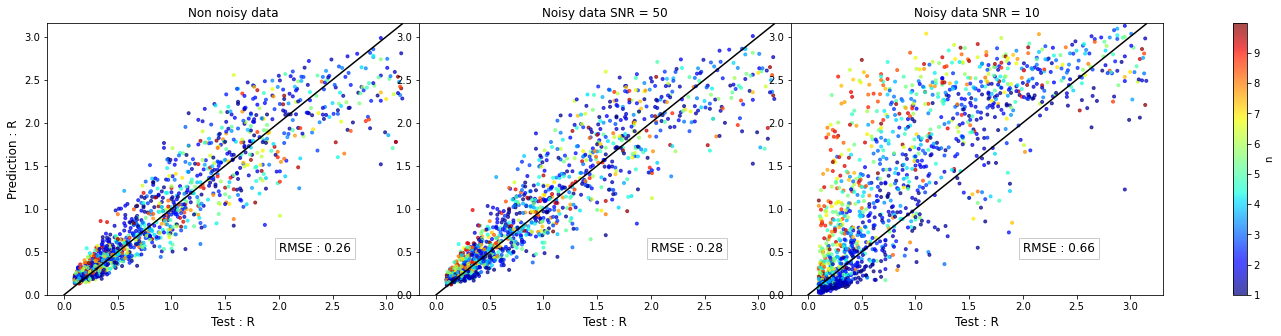

In [44]:
fig, ax =  plt.subplots(1,3, figsize = (25,5))

abscisse=np.linspace(0,np.max(Y_test_R[:,0])*4,1000)

ax[0] = plt.subplot2grid((1, 3), (0, 0), colspan=1)
ax[0].set_title("Non noisy data", size=12)
im = ax[0].scatter(Y_test_R[:,0]*4,Y_pred_R[:,0]*4,c=Y_test[:,1]*10,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[0].plot(abscisse, abscisse, 'k')
ax[0].set_xlabel('Test : R', size=12)
ax[0].set_ylabel('Prediction : R', size=12)
ax[0].text(2, 0.5, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_R*4, Y_pred_R*4)),2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.2))
ax[0].set_ylim(0,3.16)


SNR = 50
X_test_noisy = noisy_data(X_test, SNR)
Y_pred_R_noisy = modelR(X_test_noisy)
ax[1] = plt.subplot2grid((1, 3), (0, 1), colspan=1, sharey=ax[0])
ax[1].set_title("Noisy data SNR = %s"%SNR, size=12)
im = ax[1].scatter(Y_test_R[:,0]*4,Y_pred_R_noisy[:,0]*4,c=Y_test[:,1]*10,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[1].plot(abscisse, abscisse, 'k')
ax[1].set_xlabel('Test : R', size=12)
ax[1].text(2, 0.5, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_R*4, Y_pred_R_noisy*4)),2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.2))
ax[1].set_ylim(0,3.16)

SNR = 10
X_test_noisy = noisy_data(X_test, SNR)
Y_pred_R_noisy = modelR(X_test_noisy)
ax[2] = plt.subplot2grid((1, 3), (0, 2), colspan=1, sharey=ax[0])
ax[2].set_title("Noisy data SNR = %s"%SNR, size=12)
im = ax[2].scatter(Y_test_R[:,0]*4,Y_pred_R_noisy[:,0]*4,c=Y_test[:,1]*10,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[2].plot(abscisse, abscisse, 'k')
ax[2].set_xlabel('Test : R', size=12)
ax[2].text(2, 0.5, 'RMSE : %s'%np.round(np.sqrt(mean_squared_error(Y_test_R*4, Y_pred_R_noisy*4)),2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.2))
ax[2].set_ylim(0,3.16)


plt.subplots_adjust(wspace=0)
fig.colorbar(im, ax=ax, orientation='vertical', label='n')

#plt.savefig('images/noisy/corr_comp_noisy_R.png',dpi=100)

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_R = Model1(1)

model_R.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
batch_size = 64
nb_epoch = 30

history = model_R.fit(X_train, Y_train_R,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_R),
    callbacks=[model_checkpoint_callback])


model_R.load_weights(checkpoint_filepath)

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_R = model_R(X_test)
Y_pred_R.shape

In [ ]:
plot_test_pred(Y_test_R, Y_pred_R, ["R"])

In [ ]:
fig, axs = plt.subplots(5,1, figsize=(10,20))

axs[0].set_title("R corr with n")
axs[0].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,1],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[0].plot(abscisse, abscisse, 'k')
axs[0].set_xlabel('Test')
axs[0].set_ylabel('Pred')

axs[1].set_title("R corr with q")
axs[1].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,2],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[1].plot(abscisse, abscisse, 'k')
axs[1].set_xlabel('Test')
axs[1].set_ylabel('Pred')

axs[2].set_title("R corr with p")
axs[2].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,3],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[2].plot(abscisse, abscisse, 'k')
axs[2].set_xlabel('Test')
axs[2].set_ylabel('Pred')

axs[3].set_title(r"R corr with $\phi$")
axs[3].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,4],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[3].plot(abscisse, abscisse, 'k')
axs[3].set_xlabel('Test')
axs[3].set_ylabel('Pred')

axs[4].set_title(r"R corr with $\theta$")
axs[4].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,5],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[4].plot(abscisse, abscisse, 'k')
axs[4].set_xlabel('Test')
axs[4].set_ylabel('Pred')


plt.tight_layout()

In [ ]:
plot_test_pred_corr(Y_test_R,Y_pred_R, ["R corr with R"], Y_test[:,0])